In [1]:
import numpy as np 
import pandas as pd
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2
from tensorflow import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_parquet('drive/My Drive/Neural NotWork/Data/train_image_data_0.parquet', 'auto')

In [4]:
df

,image_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,32292,32293,32294,32295,32296,32297,32298,32299,32300,32301,32302,32303,32304,32305,32306,32307,32308,32309,32310,32311,32312,32313,32314,32315,32316,32317,32318,32319,32320,32321,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,253,254,253,253,253,254,253,252,253,253,253,253,252,252,253,253,252,252,253,252,252,252,253,254,253,253,252,252,252,253,...,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,252,250,250,246,249,248,250,249,251,252,253,253,253,253,253,253,253,250,249,251,252,251,251,251,251,252,253,251,250,252,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,252,253,252,252,251,250,251,253,254,251,251,252,252,253,253,252,251,251,249,251,252,252,253,252,251,251,251,250,250,252,...,253,253,252,252,252,253,253,253,253,253,252,251,251,250,250,250,251,251,251,250,250,250,251,252,253,253,253,253,254,254,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,250,251,250,249,251,251,251,250,252,251,245,245,251,252,251,252,252,250,249,250,251,250,249,250,251,252,253,252,252,252,...,253,252,252,254,253,253,254,253,252,253,254,253,252,253,254,254,254,254,254,254,254,254,253,252,253,254,253,252,253,254,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,225,231,229,229,228,221,224,226,221,221,220,217,217,218,219,222,224,214,218,227,227,227,228,224,231,235,235,233,212,183,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50205,Train_50205,247,250,250,250,252,250,250,250,251,250,251,250,251,250,251,254,253,253,253,253,253,253,253,253,253,253,253,253,253,253,254,254,254,254,253,252,251,251,251,...,251,252,251,250,248,246,248,250,252,251,250,248,245,243,244,247,251,251,249,248,248,250,253,253,249,247,249,252,252,250,246,248,252,252,249,248,250,247,243,243
50206,Train_50206,250,251,250,244,245,243,246,248,246,247,248,251,249,247,250,251,249,248,249,247,249,251,248,245,248,250,248,248,245,246,247,244,244,247,248,248,244,236,240,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,253
50207,Train_50207,246,245,246,246,245,245,247,247,245,246,246,245,246,247,247,246,247,248,245,242,244,247,247,247,247,247,244,244,246,246,245,245,247,247,246,246,247,246,244,...,244,245,247,248,246,244,245,247,248,248,247,245,242,243,244,243,246,250,249,246,247,248,246,246,247,246,245,245,246,248,247,246,248,246,245,248,249,246,243,245
50208,Train_50208,246,242,240,244,247,242,239,241,245,245,243,244,245,243,244,247,247,245,241,240,244,246,244,240,241,245,245,241,243,245,244,242,243,243,241,241,243,245,245,...,250,250,249,246,244,244,243,242,242,243,244,243,241,241,243,247,250,250,247,247,250,248,248,249,248,247,248,251,251,249,247,247,247,247,247,246,246,248,248,247


In [0]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax


HEIGHT = 137
WIDTH = 236
SIZE = 64


def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

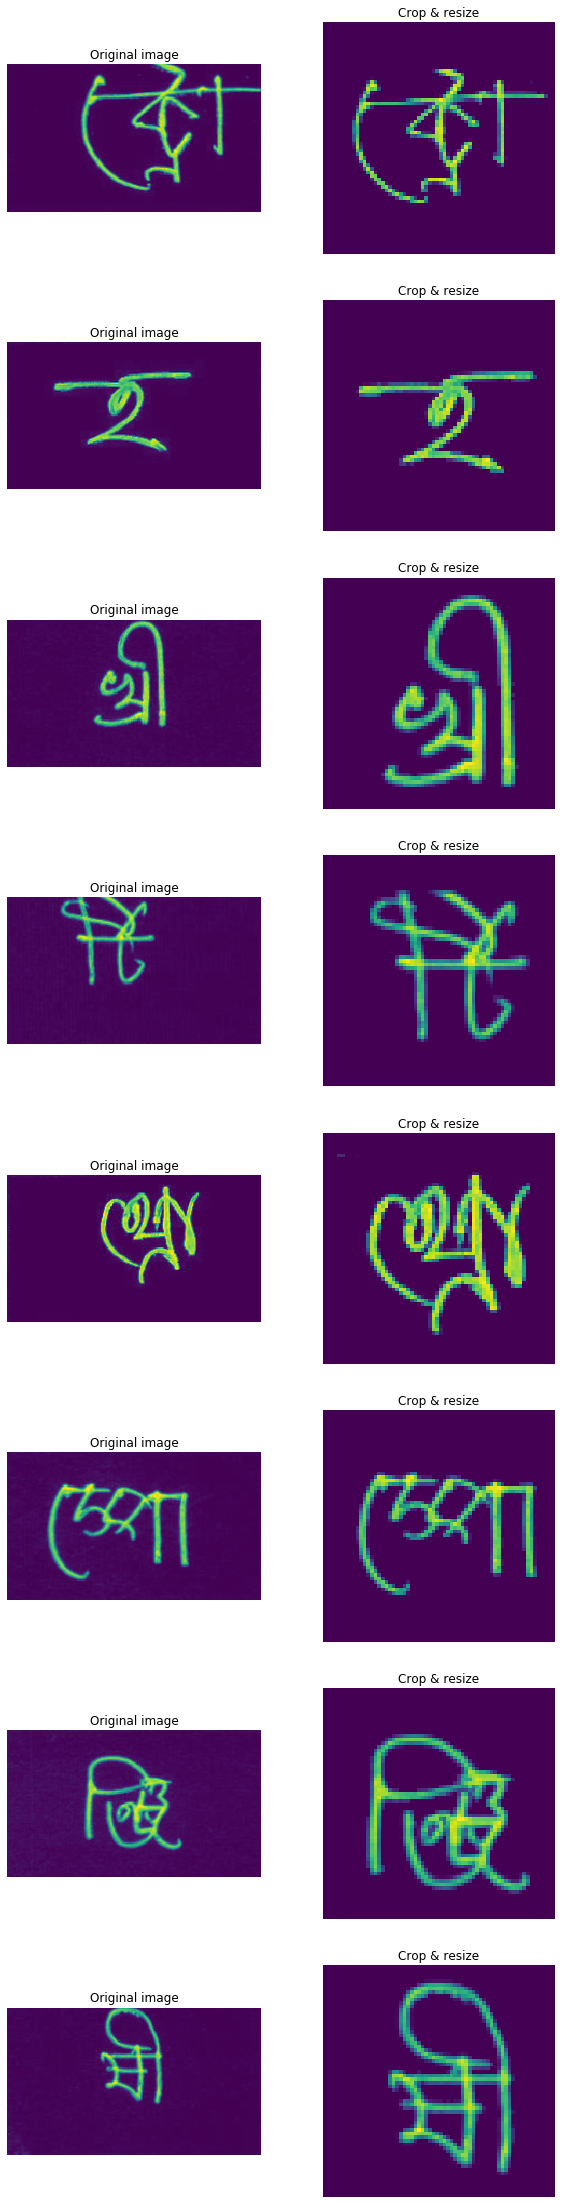

In [6]:
n_imgs = 8
fig, axs = plt.subplots(n_imgs, 2, figsize=(10, 5*n_imgs))

for idx in range(n_imgs):
    #somehow the original input is inverted
    img0 = 255 - df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
    #normalize each image by its max val
    img = (img0*(255.0/img0.max())).astype(np.uint8)
    img = crop_resize(img)

    axs[idx,0].imshow(img0)
    axs[idx,0].set_title('Original image')
    axs[idx,0].axis('off')
    axs[idx,1].imshow(img)
    axs[idx,1].set_title('Crop & resize')
    axs[idx,1].axis('off')
plt.show()